### Project 4 - Advance Lane Finding

Objective: Create a software pipeline to identify the lane boundaries in a video

Steps:
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Images folder for camera calibration: camera_cal
<br> Images folder for testing pipeline on single frames: test_images
<br> Video for processing: project_video.mp4

Version Submit: Added illustration images; video input/output; removed normal search algorithm, just use window search



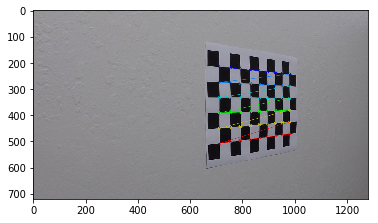

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Camera Calibration for distortion

calImages = glob.glob('./camera_cal/calibration*.jpg')          # Read in a bunch of sequential images

objpoints = []                                                  # 3D points for real world space
imgpoints = []                                                  # 2D points for image plane

objp = np.zeros((6*9,3), np.float32)                            # Prepare object points - all zeros
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)                  # x,y coordinates

for fname in calImages:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                 # Convert image to gray scale
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)   # Find the chessboard corners from image
    if ret == True:                                             # If corners are found
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

# Determine parameters for camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


Text(0.5,1,'Undistorted Image')

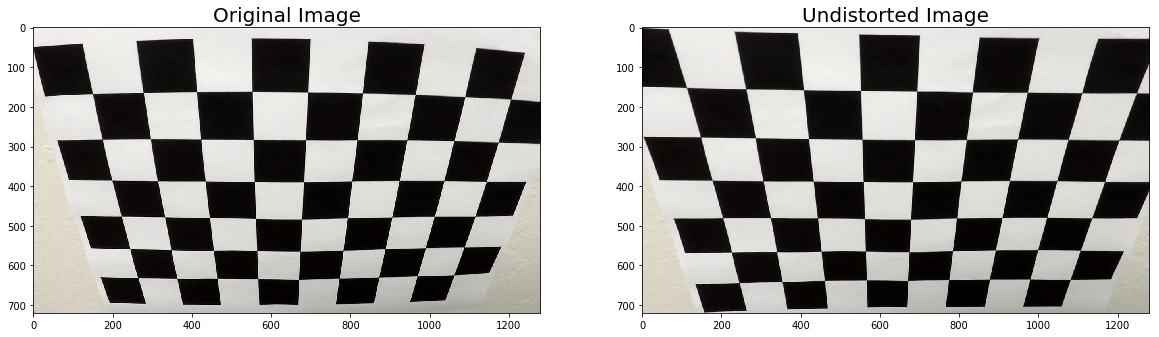

In [15]:
# Distortion Correcton for Camera Calibration Example

#
imgCalDemo = mpimg.imread('./camera_cal/calibration2.jpg')         # load camera calibration image

dstCalDemo = cv2.undistort(imgCalDemo, mtx, dist, None, mtx)       # destination image for camera calibration image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(imgCalDemo)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dstCalDemo)
ax2.set_title('Undistorted Image', fontsize=20)

Text(0.5,1,'Undistorted Image')

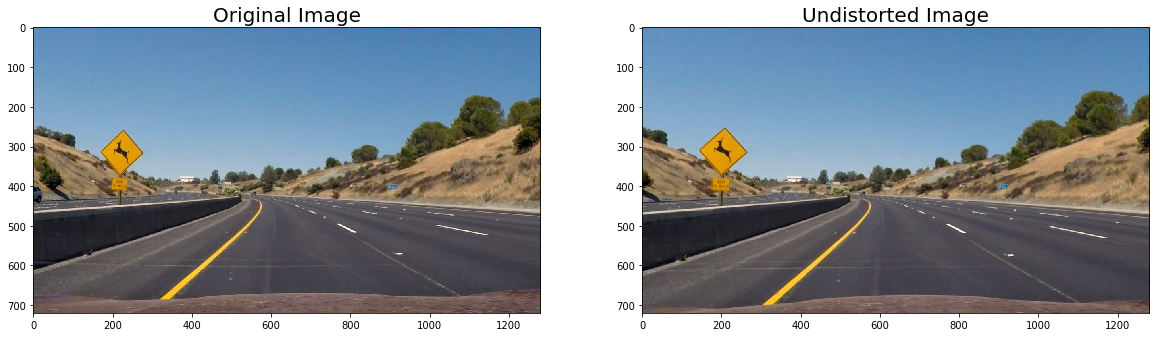

In [16]:
# Distortion Correction on Test Image Example

imgTestDemo = mpimg.imread('./test_images/test2.jpg')               # load test image

dstTestDemo = cv2.undistort(imgTestDemo, mtx, dist, None, mtx)              # Destination image - undistort input image

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(imgTestDemo)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dstTestDemo)
ax2.set_title('Undistorted Image', fontsize=20)

Text(0.5,1,'Image Ready for Lane Finding')

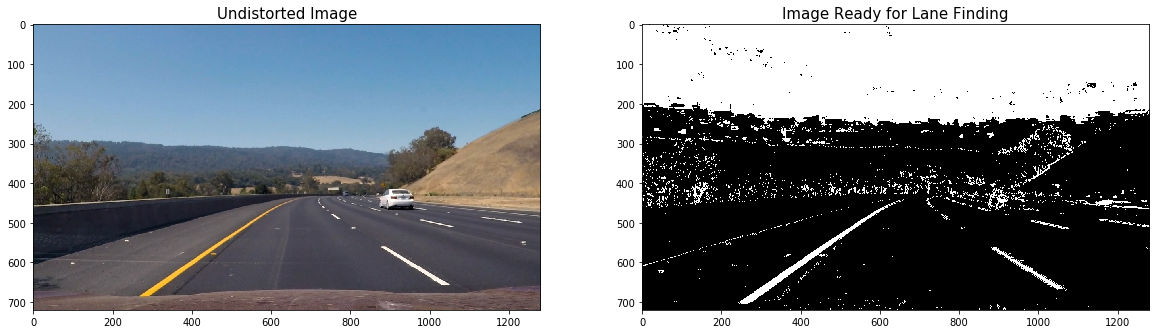

In [17]:
# Lane Finding and image processing - undistort, gray, binary, sobelx, color spaces filtering, combine 

# Threshold values
threshG = (180, 255)
threshSolX = (20, 100)
threshS = (100, 255)
threshV = (100, 255)

def ProcessImg(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)   
    gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)                  # Grayscale conversion of undistorted image
    binary = np.zeros_like(gray)                                  # Binary of grayscale
    binary[(gray > threshG[0]) & (gray <= threshG[1])] = 1
    
    # Sobel X and Thresholding
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                      # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)                                # Absolute x derivative 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))      # 8 bit conversion
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= threshSolX[0]) & (scaled_sobel <= threshSolX[1])] = 1
    
    # Color Space and Thresholding
    hls = cv2.cvtColor(dst, cv2.COLOR_RGB2HLS)                 # Convert to HLS color space
    S = hls[:,:,2]
    hsv = cv2.cvtColor(dst, cv2.COLOR_RGB2HSV)                 # Convert to HSV color space
    V = hsv[:,:,2]
    binaryS = np.zeros_like(S)
    binaryV = np.zeros_like(V)
    binaryS[(S > threshS[0]) & (S <= threshS[1])] = 1          # Create binary Saturation image
    binaryV[(V > threshV[0]) & (V <= threshV[1])] = 1          # Create binary Value image
    
    sobelxSat = cv2.Sobel(gray, cv2.CV_64F, 1, 0)                    # Take the derivative in x from Saturation image
    abs_sobelxSat = np.absolute(sobelxSat)                              # Absolute x derivative 
    scaled_sobelSat = np.uint8(255*abs_sobelxSat/np.max(abs_sobelxSat))    # 8 bit conversion
    
    # Combine V and S channel, then with Sobel X
    combine_binaryVS = np.zeros_like(binaryS)
    combine_binaryVS[(binaryS == 1) & (binaryV == 1)] = 1

    combine_binaryVSg = np.zeros_like(sxbinary)
    combine_binaryVSg[(combine_binaryVS == 1) | (sxbinary == 1)] = 1
    
    return combine_binaryVSg

# Image Processing Example on test images
imgcuv = mpimg.imread('./test_images/test3.jpg')                  # Testing image input
processedImg = ProcessImg(imgcuv)                                   # Process input image - prepare for lane detection

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(imgcuv)
ax1.set_title('Undistorted Image', fontsize=15)
ax2.imshow(processedImg, cmap='gray')
ax2.set_title('Image Ready for Lane Finding', fontsize=15)
    

Text(0.5,1,'Histogram of Top View')

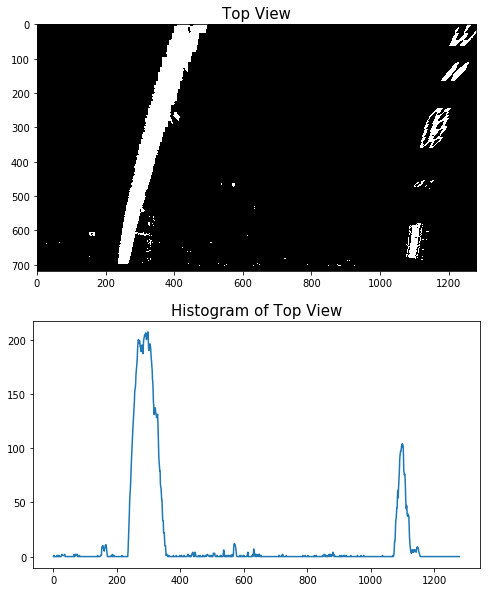

In [18]:
# Perspective Transform

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[700,460],
         [1061,695],
         [241,695],
         [580,460]])         
    dstW = np.float32(
        [[1050,0],
         [1050,695],
         [225,695],
         [225,0]])
    
    M = cv2.getPerspectiveTransform(src, dstW)                           # Get transform matrix
    Minv = cv2.getPerspectiveTransform(dstW,src)                         # Get the inverse transform matrix
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return [warped, Minv]

warped_image, Minv = warp(processedImg)

histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))
ax1.imshow(warped_image,cmap='gray')
ax1.set_title('Top View', fontsize=15)
ax2.plot(histogram)
ax2.set_title('Histogram of Top View', fontsize=15)

In [19]:
# Lane Searching and visualization Functions

# Robust Sliding Windows Search for Lane Detection
def sliding_window(warped_Frame,frame_Histogram):

    out_img = np.dstack((warped_Frame, warped_Frame, warped_Frame))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(frame_Histogram.shape[0]/2)
    leftx_base = np.argmax(frame_Histogram[:midpoint])                           # Left lane is better defined in these images
    rightx_base = np.argmax(frame_Histogram[midpoint:]) + midpoint

    nwindows = 10                                                          # Choose the number of sliding windows
    window_height = np.int(warped_Frame.shape[0]/nwindows)                 # Set height of windows

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_Frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base                          # Current positions to be updated for each window
    rightx_current = rightx_base

    margin = 100                                        # Set the width of the windows +/- margin
    minpix = 50                                         # Set minimum number of pixels found to recenter window
    left_lane_inds = []                                 # Create empty lists to receive left and right lane pixel indices
    right_lane_inds = []

    for window in range(nwindows):                      # Step through the windows one by one 
    
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_Frame.shape[0] - (window+1)*window_height       
        win_y_high = warped_Frame.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &          
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]       
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return [left_fit, right_fit, leftx, lefty, rightx, righty]


# Get Curvature
def get_Curvature (left_fit, right_fit, y_eval, leftx, lefty, rightx, righty):
    
    # In Pixel Space
    left_curveradP = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curveradP = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Curvature in meters after correcting for scale in x and y
    ym_per_pix = 30/720                                                  # meters per pixel in y dimension
    xm_per_pix = 3.7/700                                                 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curveradM = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curveradM = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return [left_curveradM, right_curveradM]


# Output frame image
def outputVideoImage (warped_image, ploty, left_fitx, right_fitx, Minv, image, CurveText, laneDepText):
    
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image and display curvature text
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_DUPLEX
    resultwText = cv2.putText(result, CurveText, (180,90), font, 2.5, (128,0,0), 3)
    resultwText = cv2.putText(resultwText, laneDepText, (180,150), font, 2.5, (128,0,0), 3)

    return resultwText


In [20]:
# Main Function for processing each video frame

def video_process(image):

    processedFrame = ProcessImg(image)                                        # undistort, filtered, binary image frame
    warpedFrame, MinvFrame = warp(processedFrame)                             # Perspective transform
    histogram = np.sum(warpedFrame[warpedFrame.shape[0]//2:,:], axis=0)       # Histogram of lane pixel
    
    leftPoly, rightPoly, lX, lY, rX, rY = sliding_window(warpedFrame,histogram)    # Use sliding window search only

    ploty = np.linspace(0, warpedFrame.shape[0]-1, warpedFrame.shape[0])
    leftPolyx = leftPoly[0]*ploty**2 + leftPoly[1]*ploty + leftPoly[2]
    rightPolyx = rightPoly[0]*ploty**2 + rightPoly[1]*ploty + rightPoly[2]
    yeval = np.max(ploty)
    
    leftCurvature, rightCurvature = get_Curvature(leftPoly, rightPoly, yeval, lX, lY, rX, rY)
    
    avgCurve = (leftCurvature + rightCurvature)/2
    
    # If the curvature is too large, it indicates that you are on a straight road
    if avgCurve > 1500:                     
        textCurve = "Curvature: Straight Lane"
    else:
        textCurve = "Curvature: {0:.1f}m".format(avgCurve)
    
    # Departure from lane center information
    xm_per_pix = 3.7/700
    laneDep = 640.0 - ((leftPoly[2]+rightPoly[2])/2)                   # Use y-intercept to determine lane positions in a 1280 pixel image
    laneDep = laneDep * xm_per_pix
    if laneDep > 0.0:                                                  # >0 means on the left-hand side of center
        laneDepText = "Left Departure: {0:.2f}m".format(np.absolute(laneDep))
    else:
        laneDepText = "Right Departure: {0:.2f}m".format(np.absolute(laneDep))
    
    resultFrame = outputVideoImage(warpedFrame, ploty, leftPolyx, rightPolyx, MinvFrame, image, textCurve, laneDepText )
    
    return resultFrame



In [21]:
# Video input and processing

windowSearch = True                                                           # Require robust sliding window search?
output_video = 'Output_Videos/LaneDetectedVideo.mp4'                  # Define output video name and location
clip = VideoFileClip("project_video.mp4")                            # Define input video
processed_clip = clip.fl_image(video_process) 
%time processed_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video Output_Videos/LaneDetectedVideo.mp4
[MoviePy] Writing video Output_Videos/LaneDetectedVideo.mp4


100%|█████████▉| 1260/1261 [03:20<00:00,  6.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_Videos/LaneDetectedVideo.mp4 

CPU times: user 3min 45s, sys: 40.9 s, total: 4min 26s
Wall time: 3min 22s
